In [1]:
import sys
import os
import json

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns


In [6]:
test_or_val = "validation"
# test_or_val = "test"

datafolder = f"./contours_compare_{test_or_val}"

root, dirs, files = next(os.walk(f"{datafolder}"))
for i, dir in enumerate(dirs):
    print(f"{i}: {dir}")



0: all_modalities
1: Dataset005_pca
2: Dataset006_pca_gg3gg4combined
3: Dataset007_pca_cribriform_only
4: Dataset008_pcaadc
5: Dataset009_pcaperf
6: t2_adc
7: t2_perfusion


In [7]:
set_number = 1

dataset = dirs[set_number]
dataset_path = f"{datafolder}/{dataset}"

In [8]:
try:
    with open(f"{dataset_path}/summary.json") as f:
        output_statistics = json.load(f)
except:
    print(f"{dataset} doesn't have a summary json. Aborting...")

### Defining a range of dice thresholds

helper functions to calculate metrics of the case of a single dice threshold \
metric used is F1-score 

$\frac{2tp}{2tp + fp + fn}$


In [17]:
def f1_score(dict_with_cm):
    TP, FP, TN, FN = dict_with_cm["TP"], dict_with_cm["FP"], dict_with_cm["TN"], dict_with_cm["FN"]

    score = 2 * TP / (2 * TP + FP + FN)
    return score

def sensitivity(dict_with_cm):
    TP, FP, TN, FN = dict_with_cm["TP"], dict_with_cm["FP"], dict_with_cm["TN"], dict_with_cm["FN"]

    score = TP / (TP + FN)
    return score

def specificity(dict_with_cm):
    TP, FP, TN, FN = dict_with_cm["TP"], dict_with_cm["FP"], dict_with_cm["TN"], dict_with_cm["FN"]

    score = TN / (TN + FP)
    return score



In [67]:
dice_thresholds = np.arange(0.025, 0.91, 0.025)
print(dice_thresholds)

[0.025 0.05  0.075 0.1   0.125 0.15  0.175 0.2   0.225 0.25  0.275 0.3
 0.325 0.35  0.375 0.4   0.425 0.45  0.475 0.5   0.525 0.55  0.575 0.6
 0.625 0.65  0.675 0.7   0.725 0.75  0.775 0.8   0.825 0.85  0.875 0.9  ]


In [68]:
gg3_f1_scores = []
gg4_f1_scores = []
cribriform_f1_scores = []

for dice_threshold in dice_thresholds:
    output_labels = output_statistics["mean"].keys()

    stats_dicts = {label:
                    {
                        "TP": 0,
                        "FP": 0,
                        "TN": 0,
                        "FN": 0,
                        # "tp_iou_scores_sum": 0 
                        "tp_dice_scores_sum": 0 
                    }
                    for label in output_labels
                }

    # The evaluation of model output statistics
    ###############
    get_avg_dice_score = lambda stats_dicts: {label: stats_dicts[label]["tp_dice_scores_sum"]/stats_dicts[label]["TP"]  if stats_dicts[label]["TP"] != 0 else 0 for label in stats_dicts.keys()}

    # For every patient
    for case in output_statistics["metric_per_case"]:
        # For every pattern output within a patient
        for pattern_num in case["metrics"].keys():
            metrics = case["metrics"][pattern_num]

            # True Negative
            if metrics["n_ref"] == 0 and metrics["n_pred"] == 0:
                stats_dicts[pattern_num]["TN"] += 1
            # False Negative
            if metrics["n_ref"] > 0 and metrics["n_pred"] == 0:
                stats_dicts[pattern_num]["FN"] += 1
            # False Positive
            if metrics["n_ref"] == 0 and metrics["n_pred"] > 0:
                stats_dicts[pattern_num]["FP"] += 1
            # True Positive
            # Only if overlap, otherwise false negative (missed a region)
            if metrics["n_ref"] > 0 and metrics["n_pred"] > 0:
                if metrics["Dice"] >= dice_threshold:
                    stats_dicts[pattern_num]["TP"] += 1
                    stats_dicts[pattern_num]["tp_dice_scores_sum"] += metrics["Dice"]
                else:
                    metrics["FN"] += 1
            

    for pattern in stats_dicts.keys():
        print(stats_dicts[pattern])

    avg_dice_scores = get_avg_dice_score(stats_dicts)
    print(f"Average Dice scores:\n{avg_dice_scores}")

    gg3_f1_scores.append(f1_score(stats_dicts["1"]))
    gg4_f1_scores.append(f1_score(stats_dicts["2"]))
    cribriform_f1_scores.append(f1_score(stats_dicts["3"]))


{'TP': 19, 'FP': 9, 'TN': 0, 'FN': 6, 'tp_dice_scores_sum': 5.898946860587767}
{'TP': 22, 'FP': 11, 'TN': 3, 'FN': 4, 'tp_dice_scores_sum': 9.747344680893157}
{'TP': 2, 'FP': 5, 'TN': 30, 'FN': 5, 'tp_dice_scores_sum': 0.38395437605000093}
Average Dice scores:
{'1': 0.31047088739935613, '2': 0.4430611218587799, '3': 0.19197718802500047}
{'TP': 19, 'FP': 9, 'TN': 0, 'FN': 6, 'tp_dice_scores_sum': 5.898946860587767}
{'TP': 22, 'FP': 11, 'TN': 3, 'FN': 4, 'tp_dice_scores_sum': 9.747344680893157}
{'TP': 2, 'FP': 5, 'TN': 30, 'FN': 5, 'tp_dice_scores_sum': 0.38395437605000093}
Average Dice scores:
{'1': 0.31047088739935613, '2': 0.4430611218587799, '3': 0.19197718802500047}
{'TP': 19, 'FP': 9, 'TN': 0, 'FN': 6, 'tp_dice_scores_sum': 5.898946860587767}
{'TP': 21, 'FP': 11, 'TN': 3, 'FN': 4, 'tp_dice_scores_sum': 9.68471230570405}
{'TP': 1, 'FP': 5, 'TN': 30, 'FN': 5, 'tp_dice_scores_sum': 0.314540059347181}
Average Dice scores:
{'1': 0.31047088739935613, '2': 0.4611767764620976, '3': 0.31454

In [69]:
print(gg3_f1_scores)
print(gg4_f1_scores)
print(cribriform_f1_scores)

[0.7169811320754716, 0.7169811320754716, 0.7169811320754716, 0.6938775510204082, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6153846153846154, 0.5714285714285714, 0.5714285714285714, 0.5714285714285714, 0.5454545454545454, 0.5454545454545454, 0.4827586206896552, 0.4827586206896552, 0.4444444444444444, 0.4444444444444444, 0.34782608695652173, 0.34782608695652173, 0.34782608695652173, 0.34782608695652173, 0.2857142857142857, 0.11764705882352941, 0.11764705882352941, 0.11764705882352941, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.7457627118644068, 0.7457627118644068, 0.7368421052631579, 0.7169811320754716, 0.7169811320754716, 0.7058823529411765, 0.6938775510204082, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6511627906976745, 0.6511627906976745, 0.6511627906976745, 0.6153846153846154, 0.5945945945945946, 0.5714285714285714, 0.5161290322580645, 0.5161290322580645, 0.51612903225806

In [70]:
sns.set_style('darkgrid')

Text(0.5, 1.0, 'All-modalities dataset F1-score for different TP-thresholds of Volumetric Dice score')

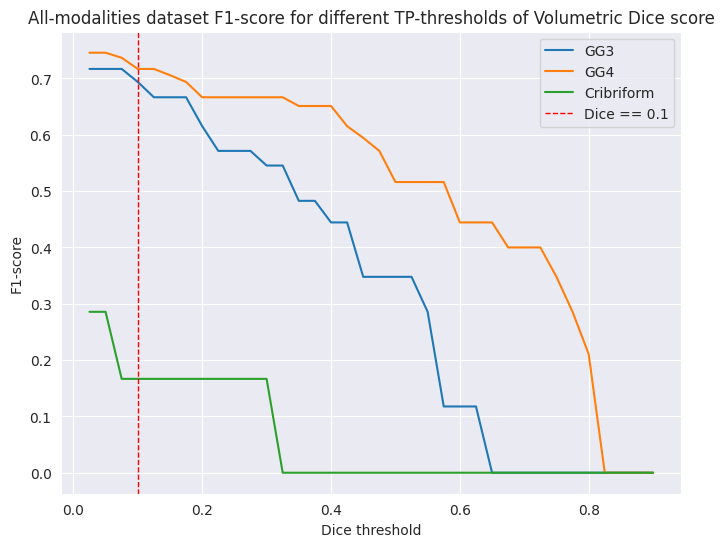

In [89]:
fig, axis = plt.subplots(figsize = (8, 6))

sns.lineplot(x = dice_thresholds, y = gg3_f1_scores, ax = axis, label = "GG3")
sns.lineplot(x = dice_thresholds, y = gg4_f1_scores, ax = axis, label = "GG4")
sns.lineplot(x = dice_thresholds, y = cribriform_f1_scores, ax = axis, label = "Cribriform")
# sns.lineplot(gg4_f1_scores)
# sns.lineplot(cribriform_f1_scores)

plt.axvline(0.1, color = "red", linestyle = "dashed", linewidth = 1, label = "Dice == 0.1")
plt.legend()
plt.xlabel("Dice threshold")
plt.ylabel("F1-score")
plt.title(f"All-modalities dataset F1-score for different TP-thresholds of Volumetric Dice score")
